# Setup

In [291]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [292]:
# read data
df = pd.read_csv(
    "../data/f1_stats_v1.csv",
    na_values=["NC", "DQ"],
    dtype={
        "Pos": np.float32,
        "No": str,
        "Driver": str,
        "Car": str,
        "Laps": str,
        "Time/Retired": str,
        "PTS": np.float32,
        "race_id": str,
        "race_date": str,
    },
)
df.columns = [c.lower().replace("/", "_") for c in df.columns]

In [293]:
# post processing
df["race_date"] = pd.to_datetime(df["race_date"])
df["race_year"] = df["race_date"].apply(lambda x: x.year)

In [294]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1500)

In [295]:
sns.set_theme()

# Selections

In [296]:
sorted(df.driver.unique())

['Alexander  Albon  ALB',
 'Antonio  Giovinazzi  GIO',
 'Carlos  Sainz  SAI',
 'Charles  Leclerc  LEC',
 'Daniel  Ricciardo  RIC',
 'Daniil  Kvyat  KVY',
 'Esteban  Ocon  OCO',
 'Fernando  Alonso  ALO',
 'George  Russell  RUS',
 'Jack  Aitken  AIT',
 'Kevin  Magnussen  MAG',
 'Kimi  Räikkönen  RAI',
 'Lance  Stroll  STR',
 'Lando  Norris  NOR',
 'Lewis  Hamilton  HAM',
 'Liam  Lawson  LAW',
 'Logan  Sargeant  SAR',
 'Max  Verstappen  VER',
 'Mick  Schumacher  MSC',
 'Nicholas  Latifi  LAT',
 'Nico  Hulkenberg  HUL',
 'Nikita  Mazepin  MAZ',
 'Nyck  De Vries  DEV',
 'Oliver  Bearman  BEA',
 'Oscar  Piastri  PIA',
 'Pierre  Gasly  GAS',
 'Pietro  Fittipaldi  FIT',
 'Robert  Kubica  KUB',
 'Romain  Grosjean  GRO',
 'Sebastian  Vettel  VET',
 'Sergio  Perez  PER',
 'Valtteri  Bottas  BOT',
 'Yuki  Tsunoda  TSU',
 'Zhou  Guanyu  ZHO']

In [297]:
df[df["driver"] == "Lance  Stroll  STR"].sort_values("race_date", ascending=False).head()

,pos,no,driver,car,laps,time_retired,pts,race_id,race_date,race_year
51,12.0,18,Lance Stroll STR,Aston Martin Aramco Mercedes,52,+1 lap,0.0,1232,2024-04-07,2024
65,6.0,18,Lance Stroll STR,Aston Martin Aramco Mercedes,58,+93.222s,8.0,1231,2024-03-24,2024
18,NaN,18,Lance Stroll STR,Aston Martin Aramco Mercedes,5,DNF,0.0,1230,2024-03-09,2024
29,10.0,18,Lance Stroll STR,Aston Martin Aramco Mercedes,57,+93.216s,1.0,1229,2024-03-02,2024
408,10.0,18,Lance Stroll STR,Aston Martin Aramco Mercedes,58,+55.632s,1.0,1226,2023-11-26,2023


In [298]:
SELECTED_DRIVERS = pd.DataFrame.from_dict(
    [
        {"driver": "Max  Verstappen  VER", "selection": 1},
        {"driver": "Lando  Norris  NOR", "selection": 5},
        {"driver": "Sergio  Perez  PER", "selection": 2},
        {"driver": "Lance  Stroll  STR", "selection": 6},
    ],
)

# Analysis

In [299]:
df.head()

,pos,no,driver,car,laps,time_retired,pts,race_id,race_date,race_year
0,1.0,1,Max Verstappen VER,Red Bull Racing Honda RBPT,50,1:20:43.273,25.0,1230,2024-03-09,2024
1,2.0,11,Sergio Perez PER,Red Bull Racing Honda RBPT,50,+13.643s,18.0,1230,2024-03-09,2024
2,3.0,16,Charles Leclerc LEC,Ferrari,50,+18.639s,16.0,1230,2024-03-09,2024
3,4.0,81,Oscar Piastri PIA,McLaren Mercedes,50,+32.007s,12.0,1230,2024-03-09,2024
4,5.0,14,Fernando Alonso ALO,Aston Martin Aramco Mercedes,50,+35.759s,10.0,1230,2024-03-09,2024


In [300]:
# filtering
import datetime


today = datetime.datetime.today()
df = df[df["race_date"] >= today.replace(year=today.year - 1)]
df = df[df["driver"].isin(df[df["race_year"] == today.year].driver.unique())]
df["pos"] = df["pos"].fillna(20)

In [301]:
# compute median position for each driver
processed_df = (
    df
    .merge(
        (
            df
                .groupby("driver")["pos"]
                .median()
                .reset_index()
                .rename(columns={"pos": "median_pos"})
        ), 
        on="driver",
    )
    .merge(
        SELECTED_DRIVERS,
        on="driver",
        how="left",
    )
    .sort_values(["selection", "median_pos"], ascending=[True, True])
)

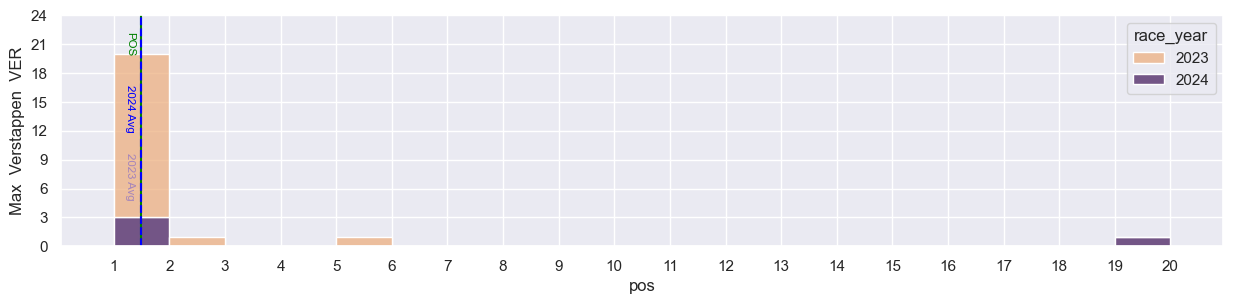

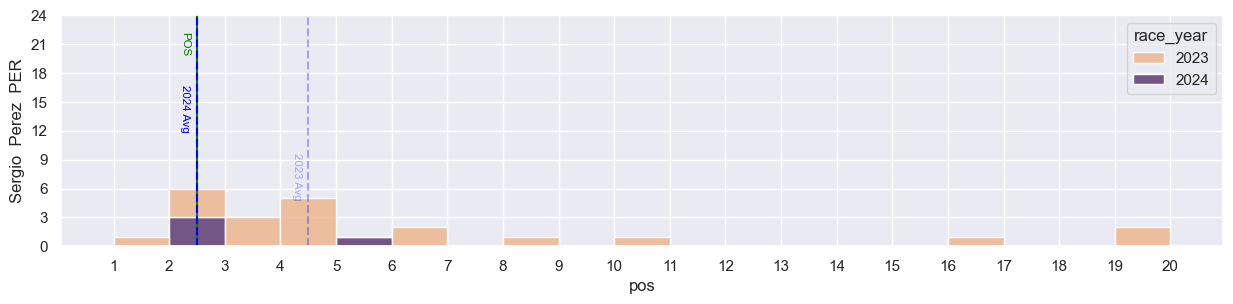

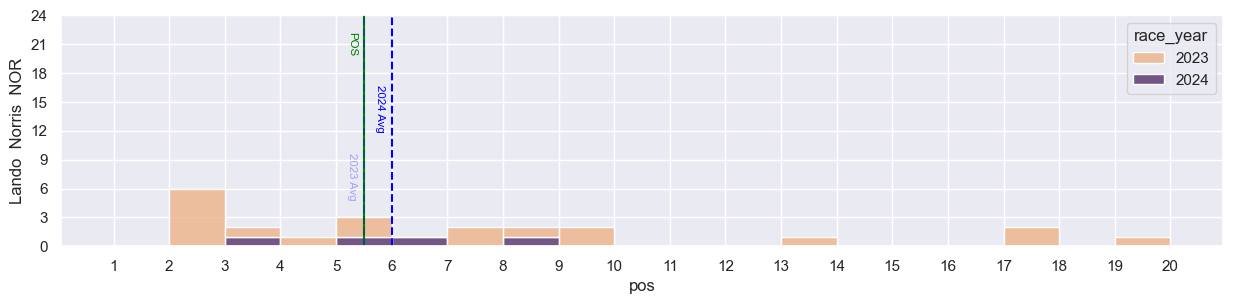

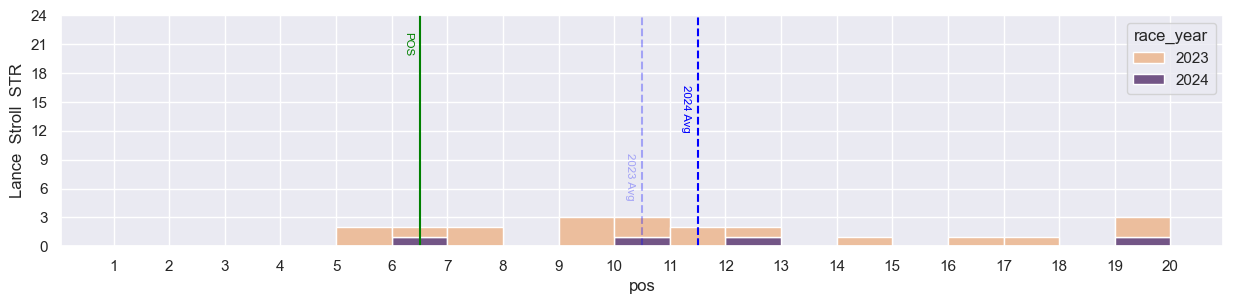

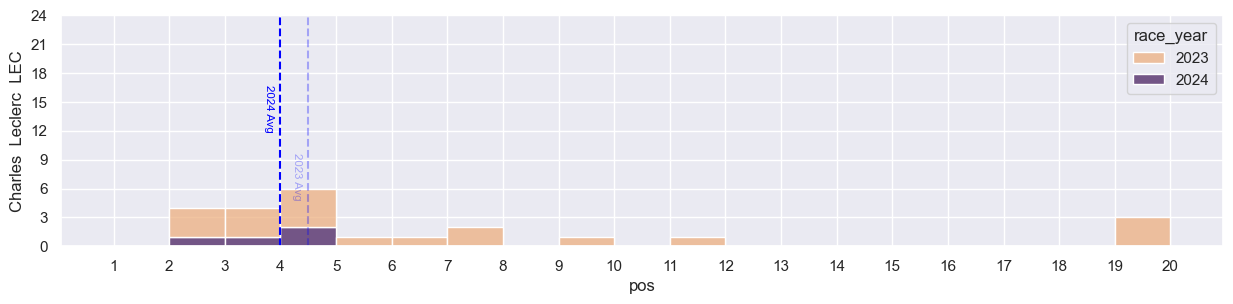

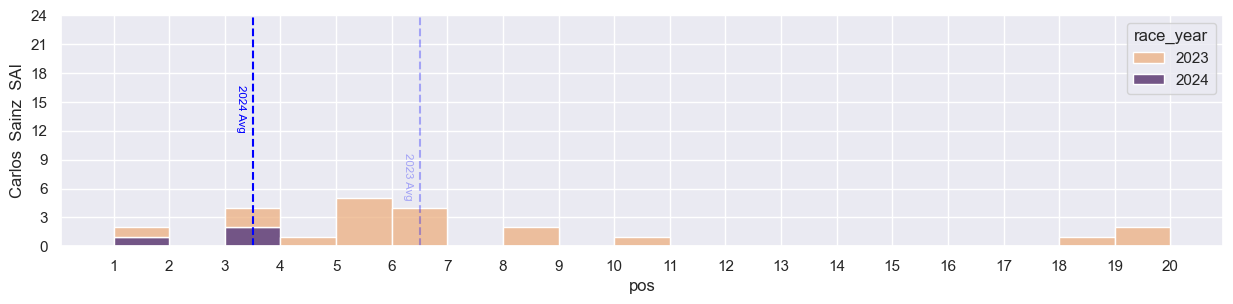

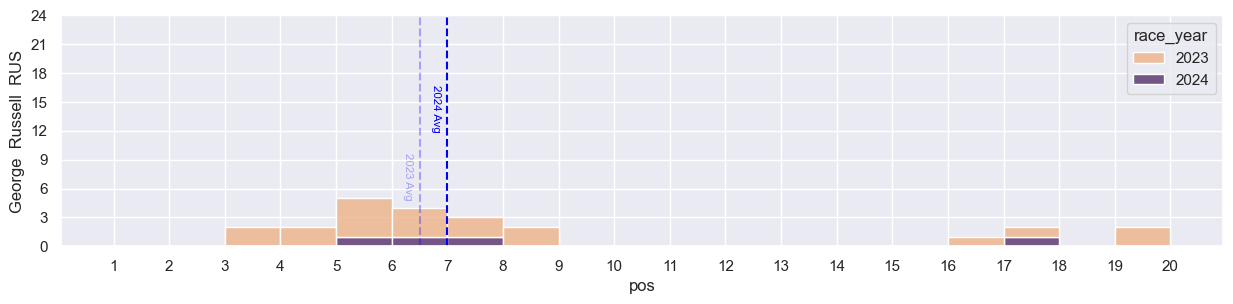

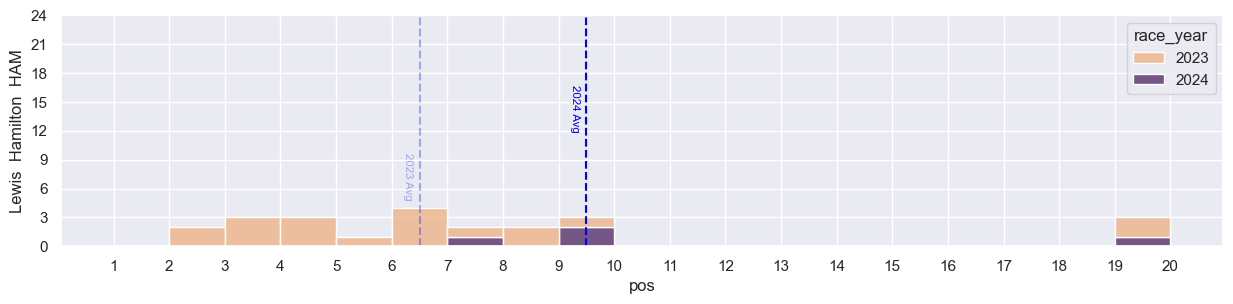

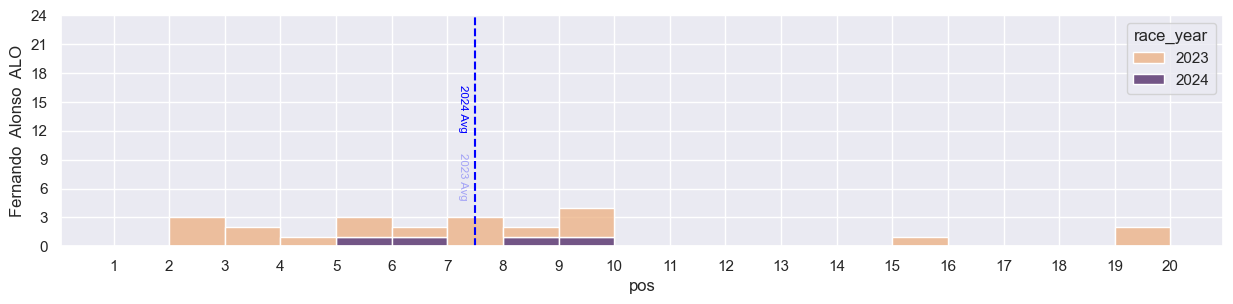

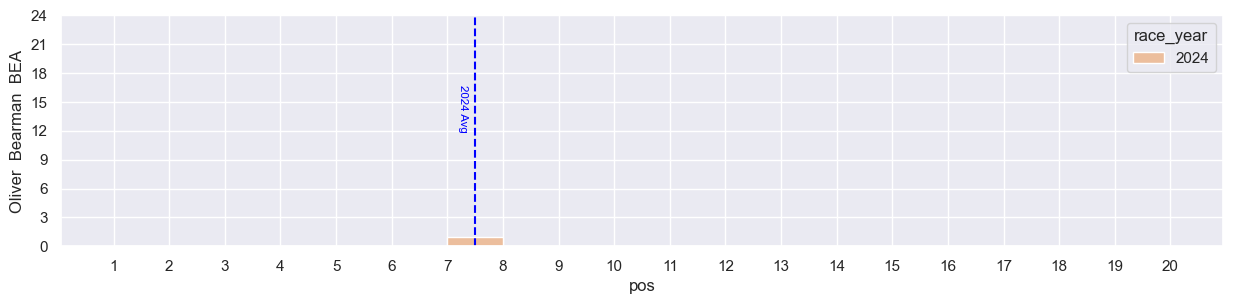

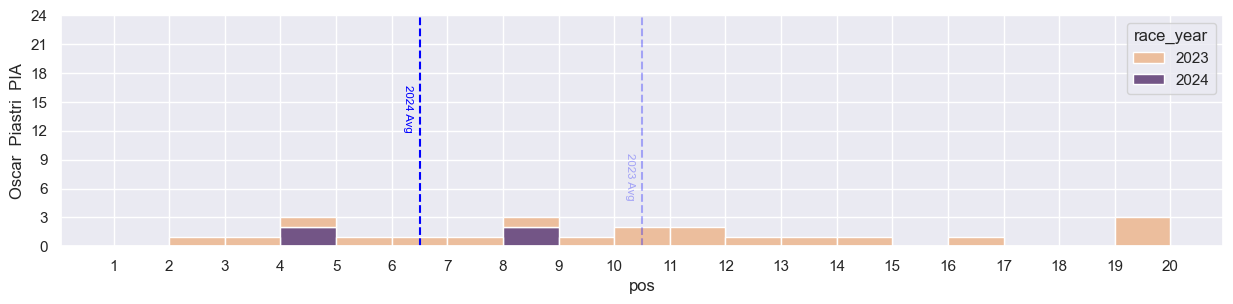

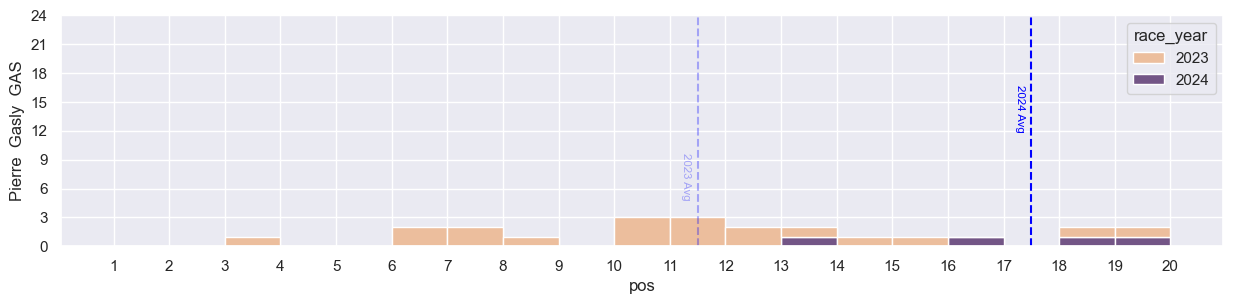

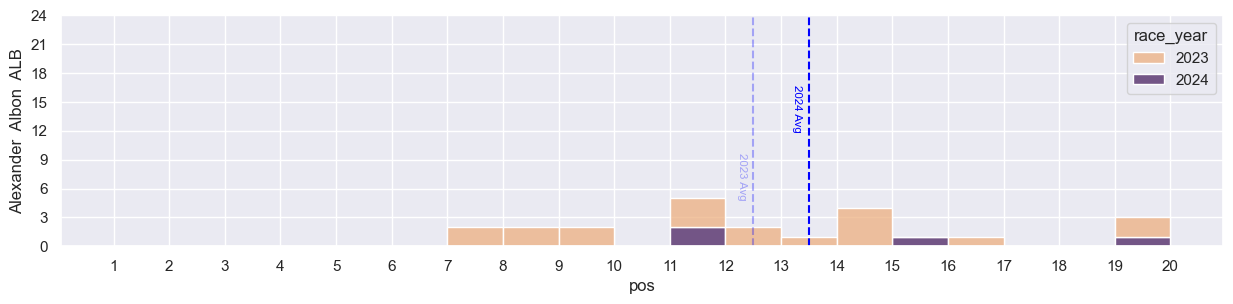

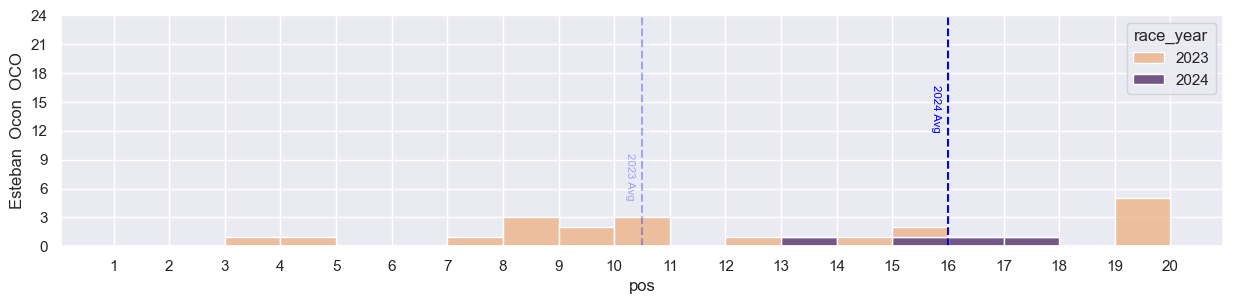

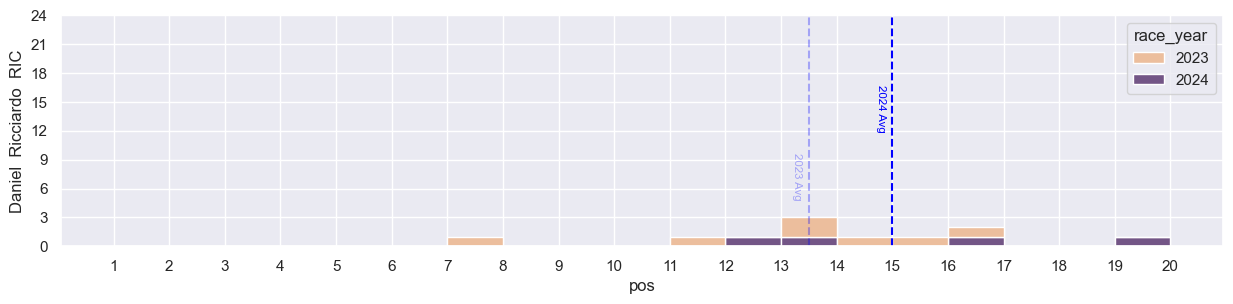

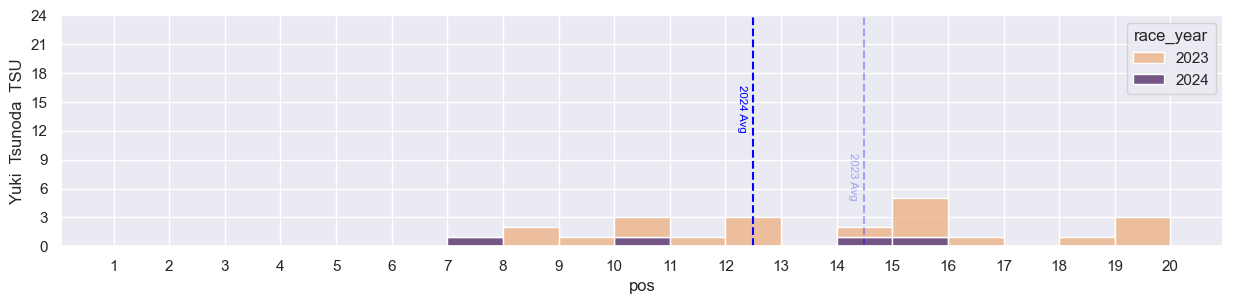

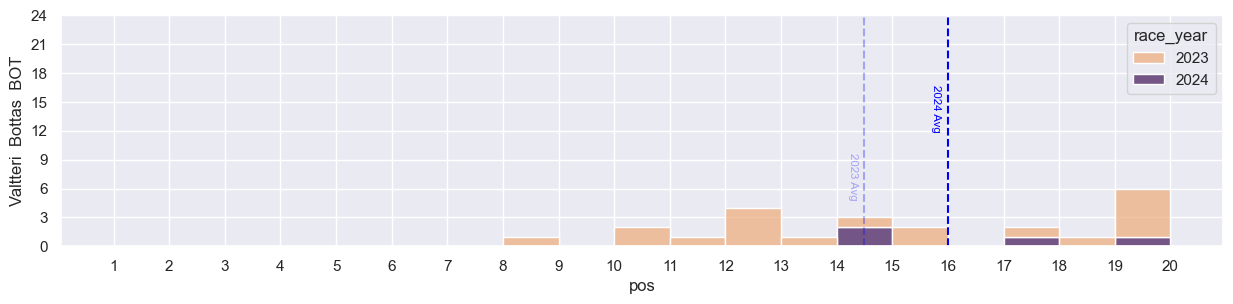

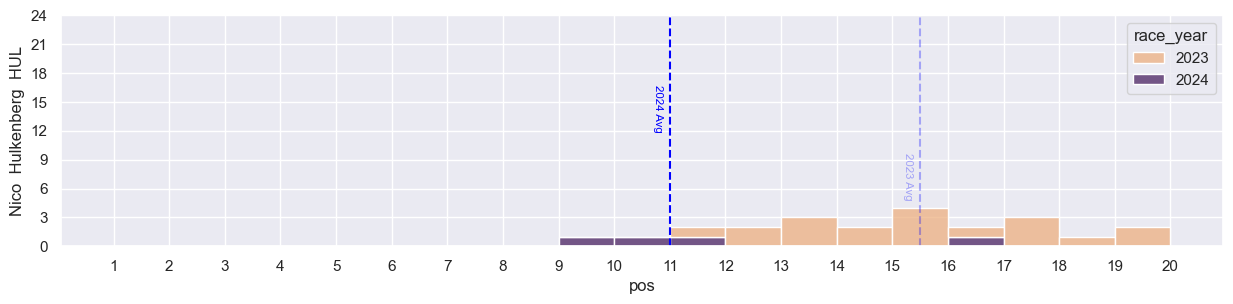

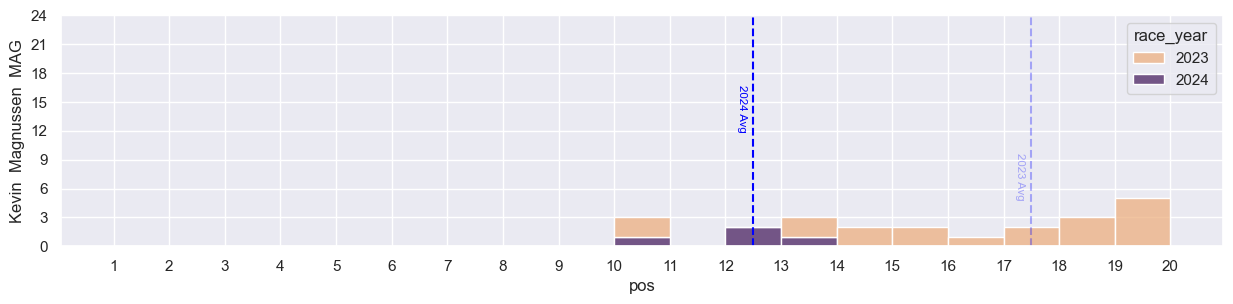

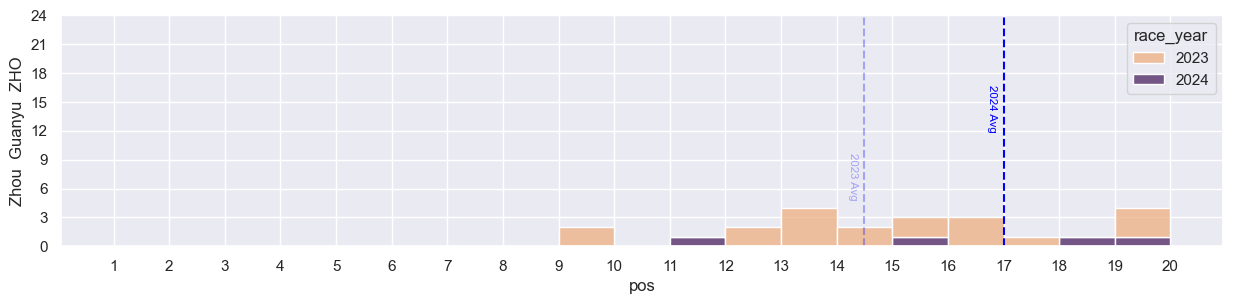

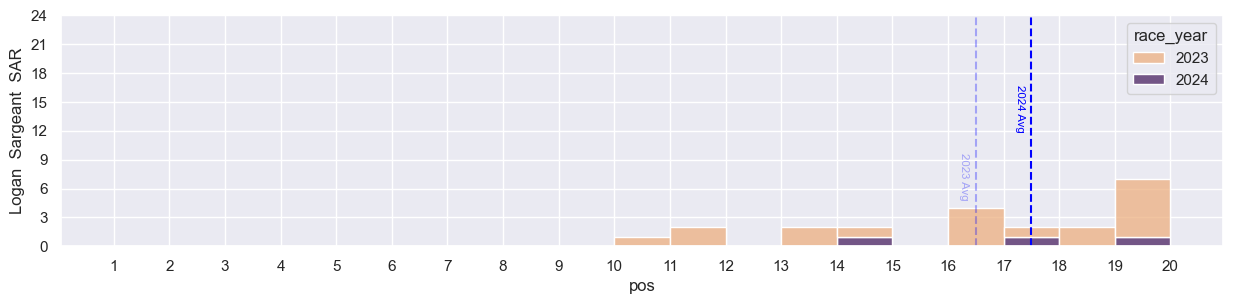

In [364]:
for driver in processed_df.driver.unique():
    driver_df = processed_df[processed_df["driver"] == driver]
    
    avg_pos_2024 = driver_df[driver_df["race_year"] == 2024]["pos"].median() + 0.5
    avg_pos_2023 = driver_df[driver_df["race_year"] == 2023]["pos"].median() + 0.5
    selection = driver_df["selection"].max() + 0.5
    
    _, _ = plt.subplots(figsize=(15, 3))
    ax = sns.histplot(
        data=driver_df, 
        x="pos", 
        bins=range(1, 21),
        hue="race_year",
        multiple="stack",
        palette="flare",
    )
    ax.axvline(
        selection,
        color="green",
    )
    ax.axvline(
        avg_pos_2024,
        color="blue",
        linestyle="--",
    )
    ax.axvline(
        avg_pos_2023,
        color="blue",
        linestyle="--",
        alpha=.3,
    )
    if selection >= 0:
        ax.text(selection - 0.3, 20, "POS", rotation=270, fontsize="x-small", color="green")
    if avg_pos_2024 >= 0:
        ax.text(avg_pos_2024 - 0.3, 12, "2024 Avg", rotation=270, fontsize="x-small", color="blue")
    if avg_pos_2023 >= 0:
        ax.text(avg_pos_2023 - 0.3, 5, "2023 Avg", rotation=270, fontsize="x-small", color="blue", alpha=.3)
    ax.set_xticks(range(1, 21))
    ax.set_yticks(range(0, 25, 3))
    ax.set_ylabel(driver)
    plt.show()